<a href="https://colab.research.google.com/github/jeanmhuang/Momentum-Streamlit-Demo/blob/main/momentum_backtest_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

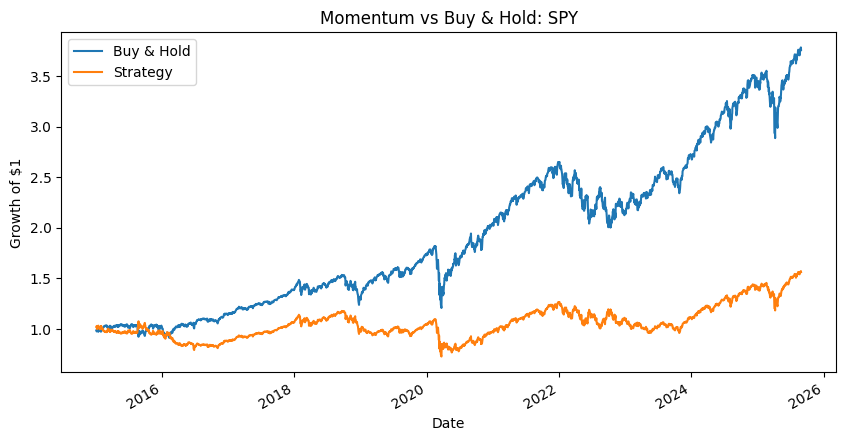

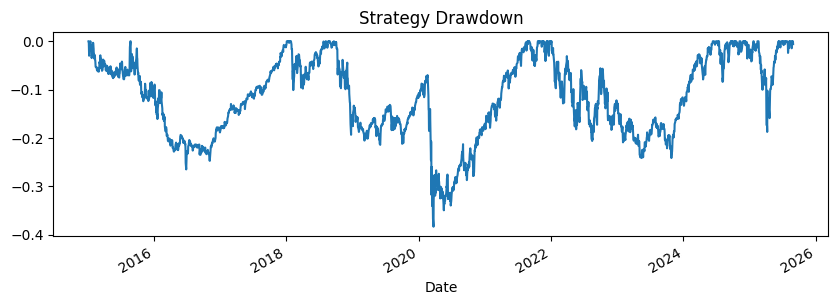

In [3]:
!pip install --quiet yfinance matplotlib pandas

import yfinance as yf, pandas as pd, numpy as np, matplotlib.pyplot as plt

# --- Parameters ---
ticker = "SPY"
start = "2015-01-01"
lookback = 252    # ~12 months
skip_recent = 21  # ~1 month
allow_short = True
tc_bps = 10       # transaction cost per side

# --- Data ---
data = yf.download(ticker, start=start, auto_adjust=True, progress=False)
# Use 'Close' price as 'Adj Close' is not available
px = data["Close"]
ret = px.pct_change()

# --- Momentum signal (12-1 proxy) ---
signal = px.pct_change(lookback) - px.pct_change(skip_recent)

# --- Positions ---
# Ensure signal is treated as 1-dimensional
pos = np.where(signal.iloc[:, 0] > 0, 1, -1 if allow_short else 0)
# Create a pandas Series from the numpy array, using the index from px
pos = pd.Series(pos, index=px.index).shift(1).fillna(0)

# --- Strategy returns with simple TC ---
turnover = pos.diff().abs().fillna(0)
tc = (tc_bps/10000.0) * turnover
strat = pos * ret.iloc[:, 0] - tc

# --- Equity curves ---
eq = pd.DataFrame({
    "Buy & Hold": (1+ret.iloc[:, 0]).cumprod(),
    "Strategy": (1+strat).cumprod()
})

eq.plot(figsize=(10,5), title=f"Momentum vs Buy & Hold: {ticker}")
plt.ylabel("Growth of $1")
plt.show()

# --- Drawdown ---
dd = (1+strat).cumprod() / (1+strat).cumprod().cummax() - 1
dd.plot(figsize=(10,3), title="Strategy Drawdown")
plt.show()